## 대응표본 T검정

- 표본의 각 사례마다 대응하는 2개의 관측치를 통해 판단

- 한 집단에 어떤 작용이 가해졌을 때에 대한 before, after를 비교 

In [16]:
import warnings 
warnings.filterwarnings(action='ignore')

import sys 
import seaborn as sns 
from math import sqrt
import matplotlib.pyplot as plt 
import pandas as pd 
import numpy as np 
from scipy.stats import t, normaltest, bartlett, levene, ttest_rel, mannwhitneyu
from statannotations.Annotator import Annotator

In [17]:
plt.rcParams['font.family'] = 'AppleGothic' if sys.platform == 'darwin' else 'Malgun Gothic'
plt.rcParams['font.size'] = 9 
plt.rcParams['figure.figsize'] = (15, 6)
plt.rcParams["figure.dpi"] = 200
plt.rcParams['axes.unicode_minus'] = False

### 예제1 - 사슴의 다리 길이 비교

- 사슴의 두 다리의 길이가 같은지 아닌지 비교

In [18]:
origin = pd.read_excel("https://data.hossam.kr/mldata/deer.xlsx", index_col="사슴")
origin

,앞다리,뒷다리
사슴,,
1,138,142
2,136,140
3,147,144
4,139,144
5,143,142
6,141,146
7,143,149
8,145,150
9,136,142


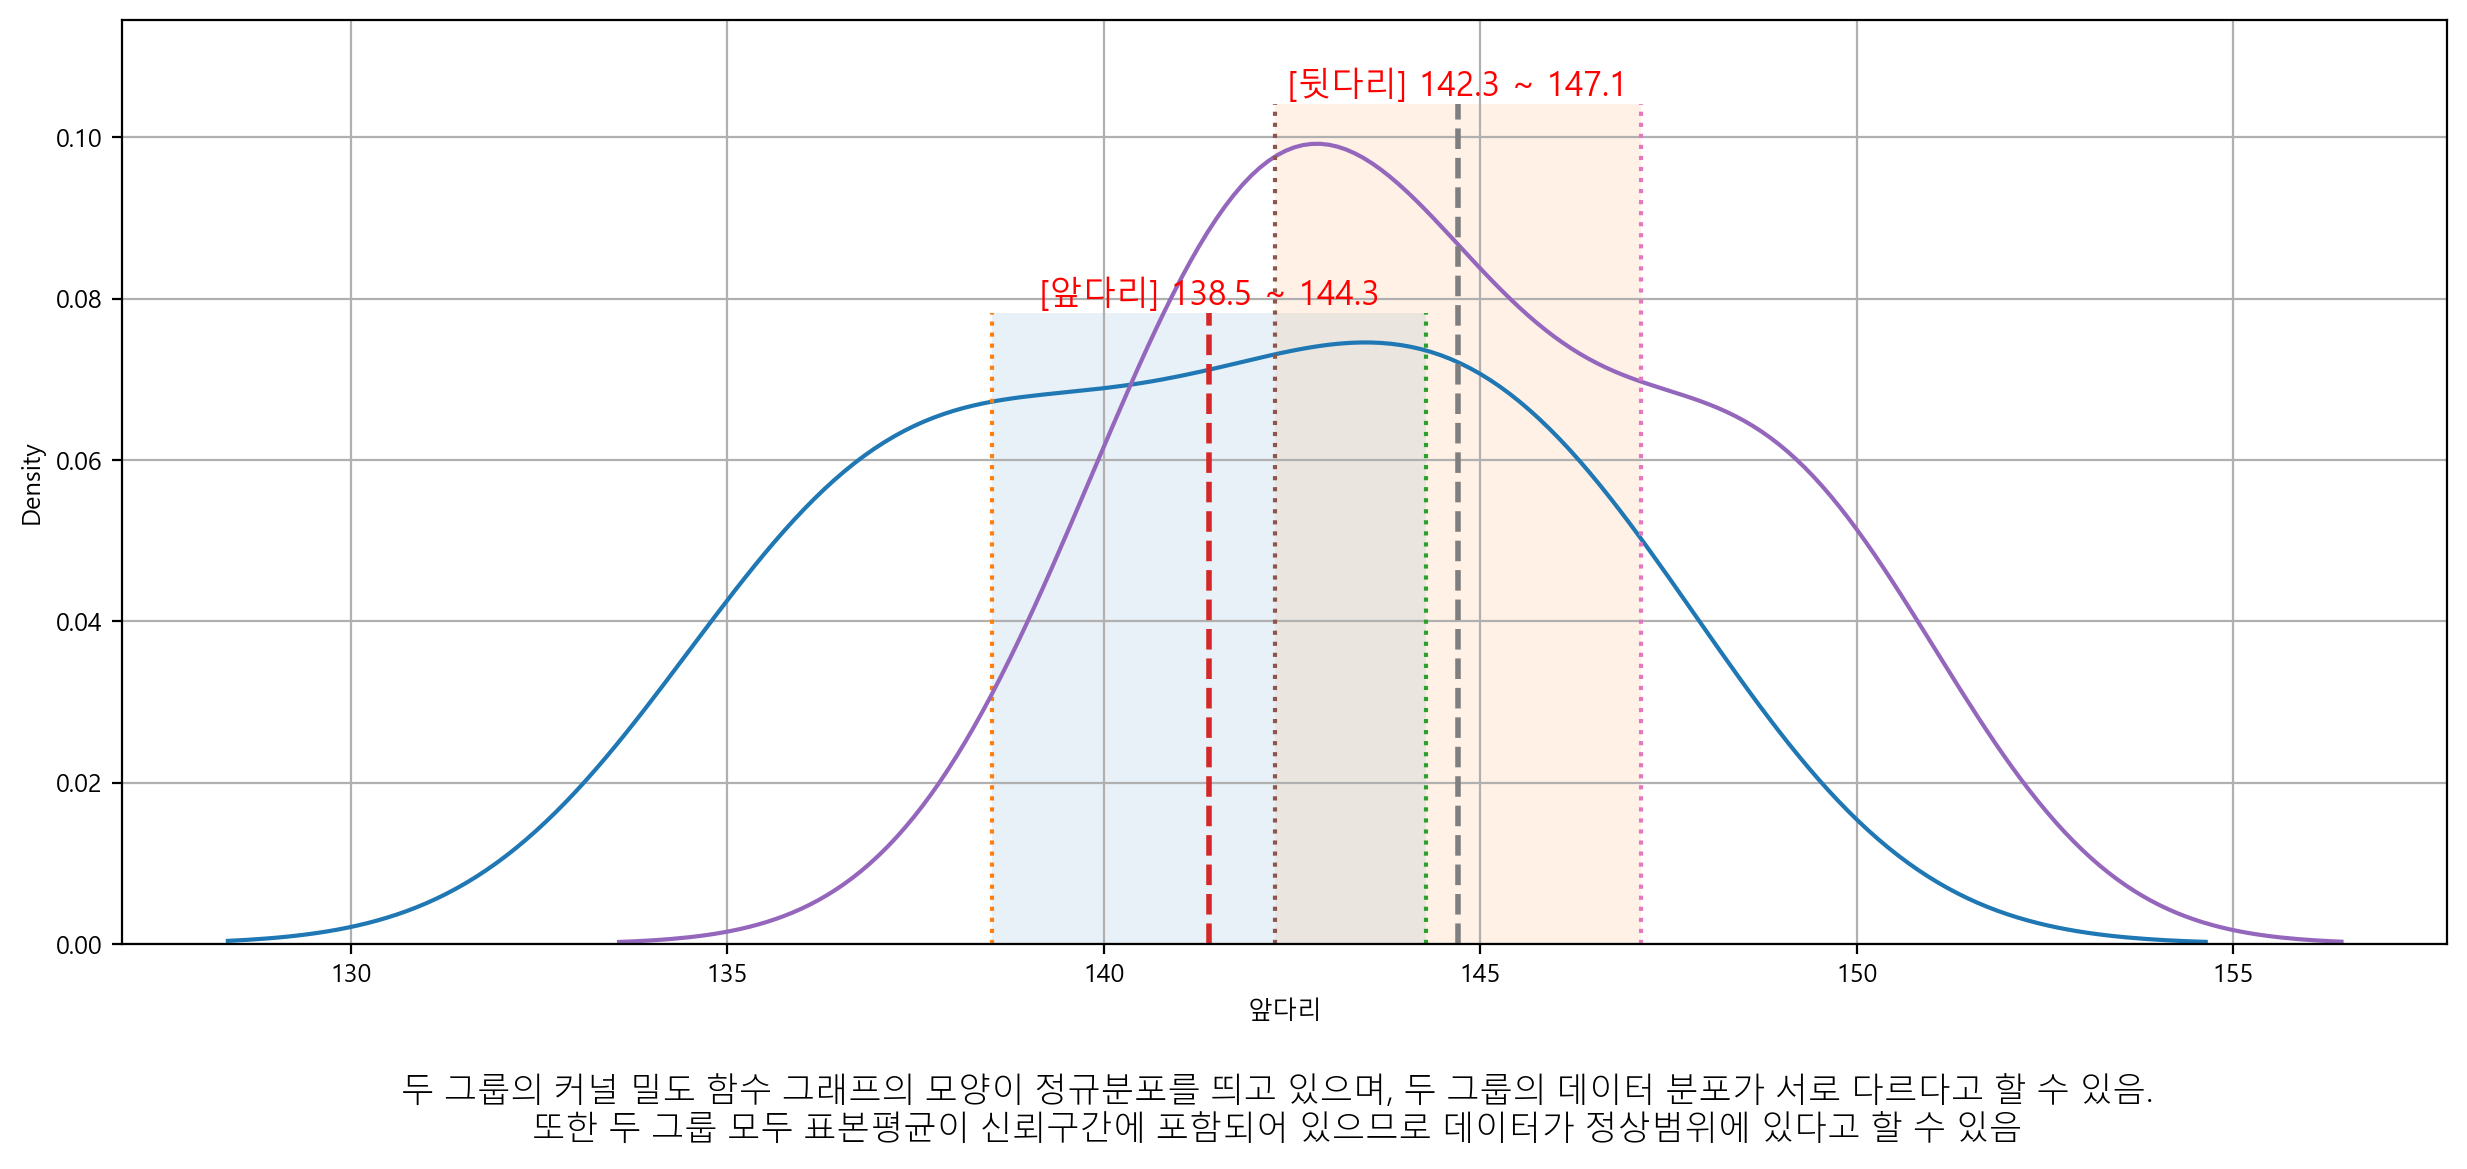

In [19]:
# 신뢰구간

plt.figure()

for c in origin.columns:
    
    data = origin[c]                                 # 데이터만 추출
    max = data.max()                                 # 최댓값
    clevel = 0.95                                    # 신뢰수준
    dof = len(data) - 1                              # 자유도
    sample_mean = data.mean()                        # 표본평균
    sample_std = data.std(ddof=1)                    # 표본표준편차
    sample_std_error = sample_std / sqrt(len(data))  # 표본표준오차
    
    # 신뢰구간
    cmin, cmax = t.interval(clevel, dof, loc=sample_mean, scale=sample_std_error)
    
    sns.kdeplot(data=data)
    
    xmin, xmax, ymin, ymax = plt.axis()
    
    # 신뢰구간 그리기 
    plt.plot([cmin, cmin], [0, ymax], linestyle=":")
    plt.plot([cmax, cmax], [0, ymax], linestyle=":")
    plt.fill_between([cmin, cmax], y1=0, y2=ymax, alpha=0.1)
    
    # 평균 그리기 
    plt.plot([sample_mean, sample_mean], [0, ymax], linestyle="--", linewidth=2)
    
    plt.text(x=(cmax - cmin) / 2 + cmin,
             y = ymax, 
             s="[%s] %0.1f ~ %0.1f" % (c, cmin, cmax),
             horizontalalignment="center",
             verticalalignment="bottom",
             fontdict={"size" : 12, "color": "red"})
    
txt = """두 그룹의 커널 밀도 함수 그래프의 모양이 정규분포를 띄고 있으며, 두 그룹의 데이터 분포가 서로 다르다고 할 수 있음.
또한 두 그룹 모두 표본평균이 신뢰구간에 포함되어 있으므로 데이터가 정상범위에 있다고 할 수 있음"""

plt.figtext(0.51, 0, txt, wrap=True, 
            verticalalignment="top", horizontalalignment="center",
            fontdict={"size" : 12, "weight": "light"})
plt.ylim(0, ymax * 1.1)
plt.grid()
plt.show()

In [20]:
# 정규성 검정
for c in origin.columns:
    s, p = normaltest(origin[c])
    print("[{0}] statistic: {1:.3f}, p-value: {2:.3f}, 정규성 충족 여부 : {3}".format(c, s, p, p > 0.05))

[앞다리] statistic: 1.824, p-value: 0.402, 정규성 충족 여부 : True
[뒷다리] statistic: 1.377, p-value: 0.502, 정규성 충족 여부 : True


In [21]:
# 등분산성
normal_dist = True         # 정규성 만족 여부 
data = origin.copy()       # 원본 데이터 복사 
fields = list(map(lambda x : data[x], data.columns))

if normal_dist:
    n = "Bartlett"
    s, p = bartlett(*fields)
    
else:
    n = "Levene"
    s, p = levene(*fields)
    
print("{0} 검정: statistic: {1:.3f}, p-value: {2:.3f}, 등분산성 충족 여부: {3}".format(n, s, p, p > 0.05))

Bartlett 검정: statistic: 0.247, p-value: 0.619, 등분산성 충족 여부: True


In [22]:
# 두 그룹의 평균 비교 
s, p = ttest_rel(origin['앞다리'], origin['뒷다리'], alternative="two-sided")
"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(s, p, "대립" if p <= 0.05 else "귀무")

'statistic: -3.414, p-value: 0.008, 대립가설 채택'

In [23]:
# 귀무가설 : 앞다리가 뒷다리보다 길지 않다
# 대립가설 : 앞다리가 뒷다리보다 길다
 
s, p = ttest_rel(origin['앞다리'], origin['뒷다리'], alternative="greater")
"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(s, p, "대립" if p <= 0.05 else "귀무")

'statistic: -3.414, p-value: 0.996, 귀무가설 채택'

In [24]:

s, p = ttest_rel(origin['앞다리'], origin['뒷다리'], alternative="less")
"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(s, p, "대립" if p <= 0.05 else "귀무")

'statistic: -3.414, p-value: 0.004, 대립가설 채택'

#### 가설검정 시각화

In [25]:
df = pd.melt(origin, var_name="group", value_name="value")
df

,group,value
0,앞다리,138
1,앞다리,136
2,앞다리,147
3,앞다리,139
4,앞다리,143
5,앞다리,141
6,앞다리,143
7,앞다리,145
8,앞다리,136
9,앞다리,146


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

앞다리 vs. 뒷다리: t-test paired samples, P_val:7.703e-03 t=-3.414e+00


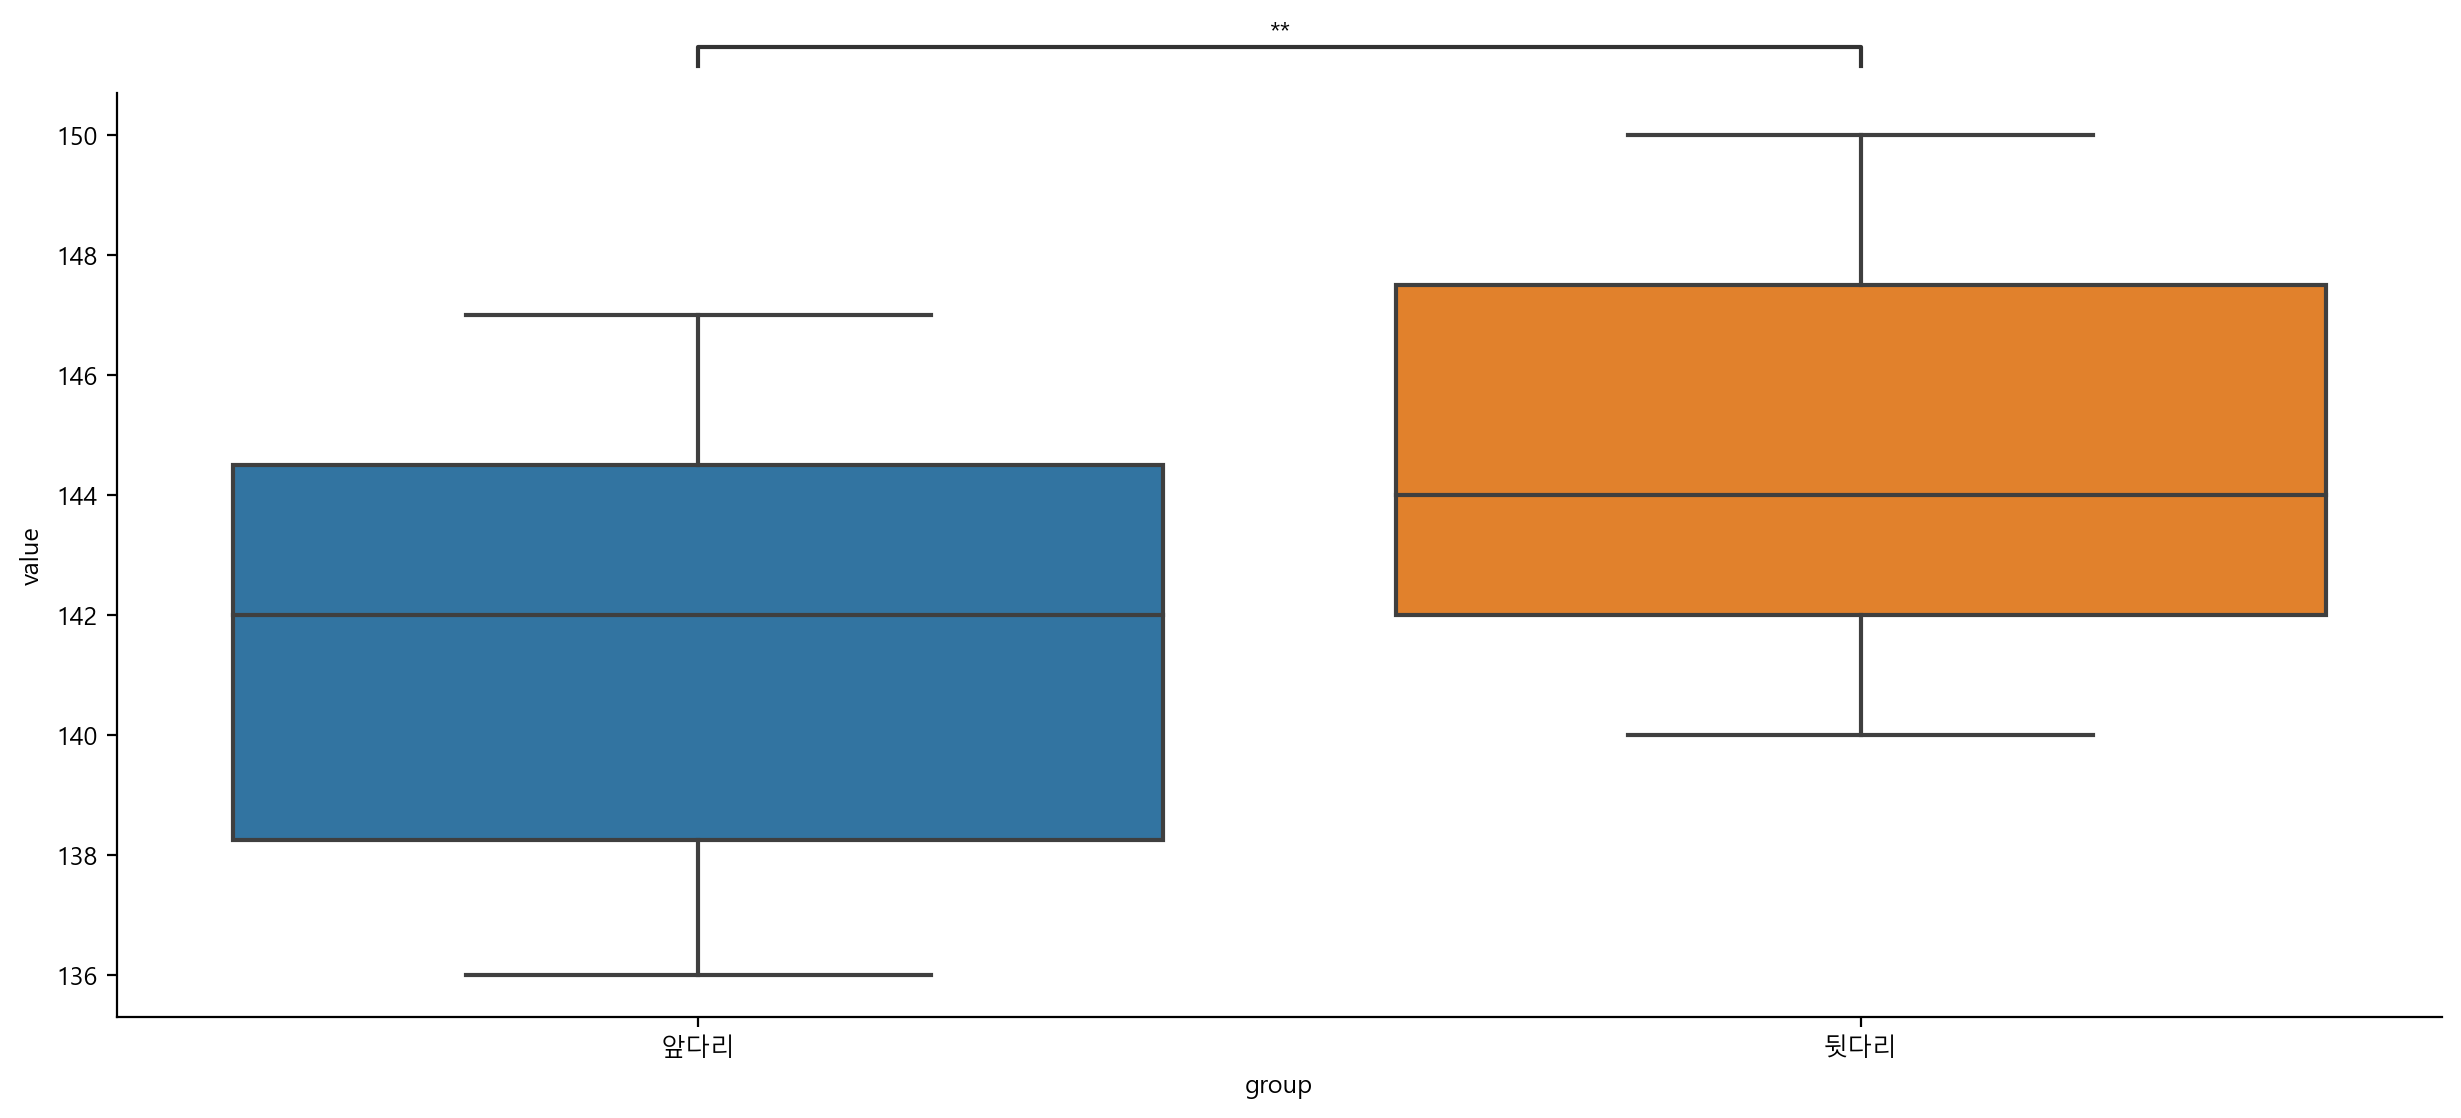

In [26]:
config = {
    "data": df, 
    "x": "group",
    "y": "value",
    "pairs": [("앞다리", "뒷다리")],
    "test": "t-test_paired", # t-test_ind, t-test_paired, t-test_welch, Mann-Whitney
    "text_format": "star", # full, simple, star
    "loc": "outside"       # outside, inside
}

plt.figure()
ax = sns.boxplot(data=config['data'], x = config['x'], y = config['y'])
ax.get_xaxis().axis_name 

annotator = Annotator(ax, data = config['data'], x = config['x'], y = config['y'], pairs=config['pairs'])
annotator.configure(test=config['test'], text_format=config['text_format'], loc=config['loc'])
annotator.apply_and_annotate()

sns.despine()
plt.show()

#### 예제2 - 자동차 첨가제가 주행거리에 미치는 영향

- 다섯 종류의 새 차에 대하여 같은 종류의 차 두 대 중에서 한 대를 랜덤하게 선택하여 첨가제를 사용하고, 다른 한 대에는 첨가제를 사용하지 않고 같은 운전자가 같은 장소에서 운전한 결과 다음과 같은 자료를 얻었다고 가정

- 첨가제를 사용하면 주행거리가 늘어난다고 할 수 있는지 유의수준 5%에서 검정

In [27]:
origin = pd.read_excel("../rawdata/oil.xlsx")
origin

,그룹A,그룹B
0,13.2,11.8
1,13.1,13.9
2,16.3,12.1
3,14.9,10.5
4,14.2,9.3
5,16.1,16.3
6,15.1,15.1
7,13.6,12.3
8,15.8,11.6
9,14.2,8.4


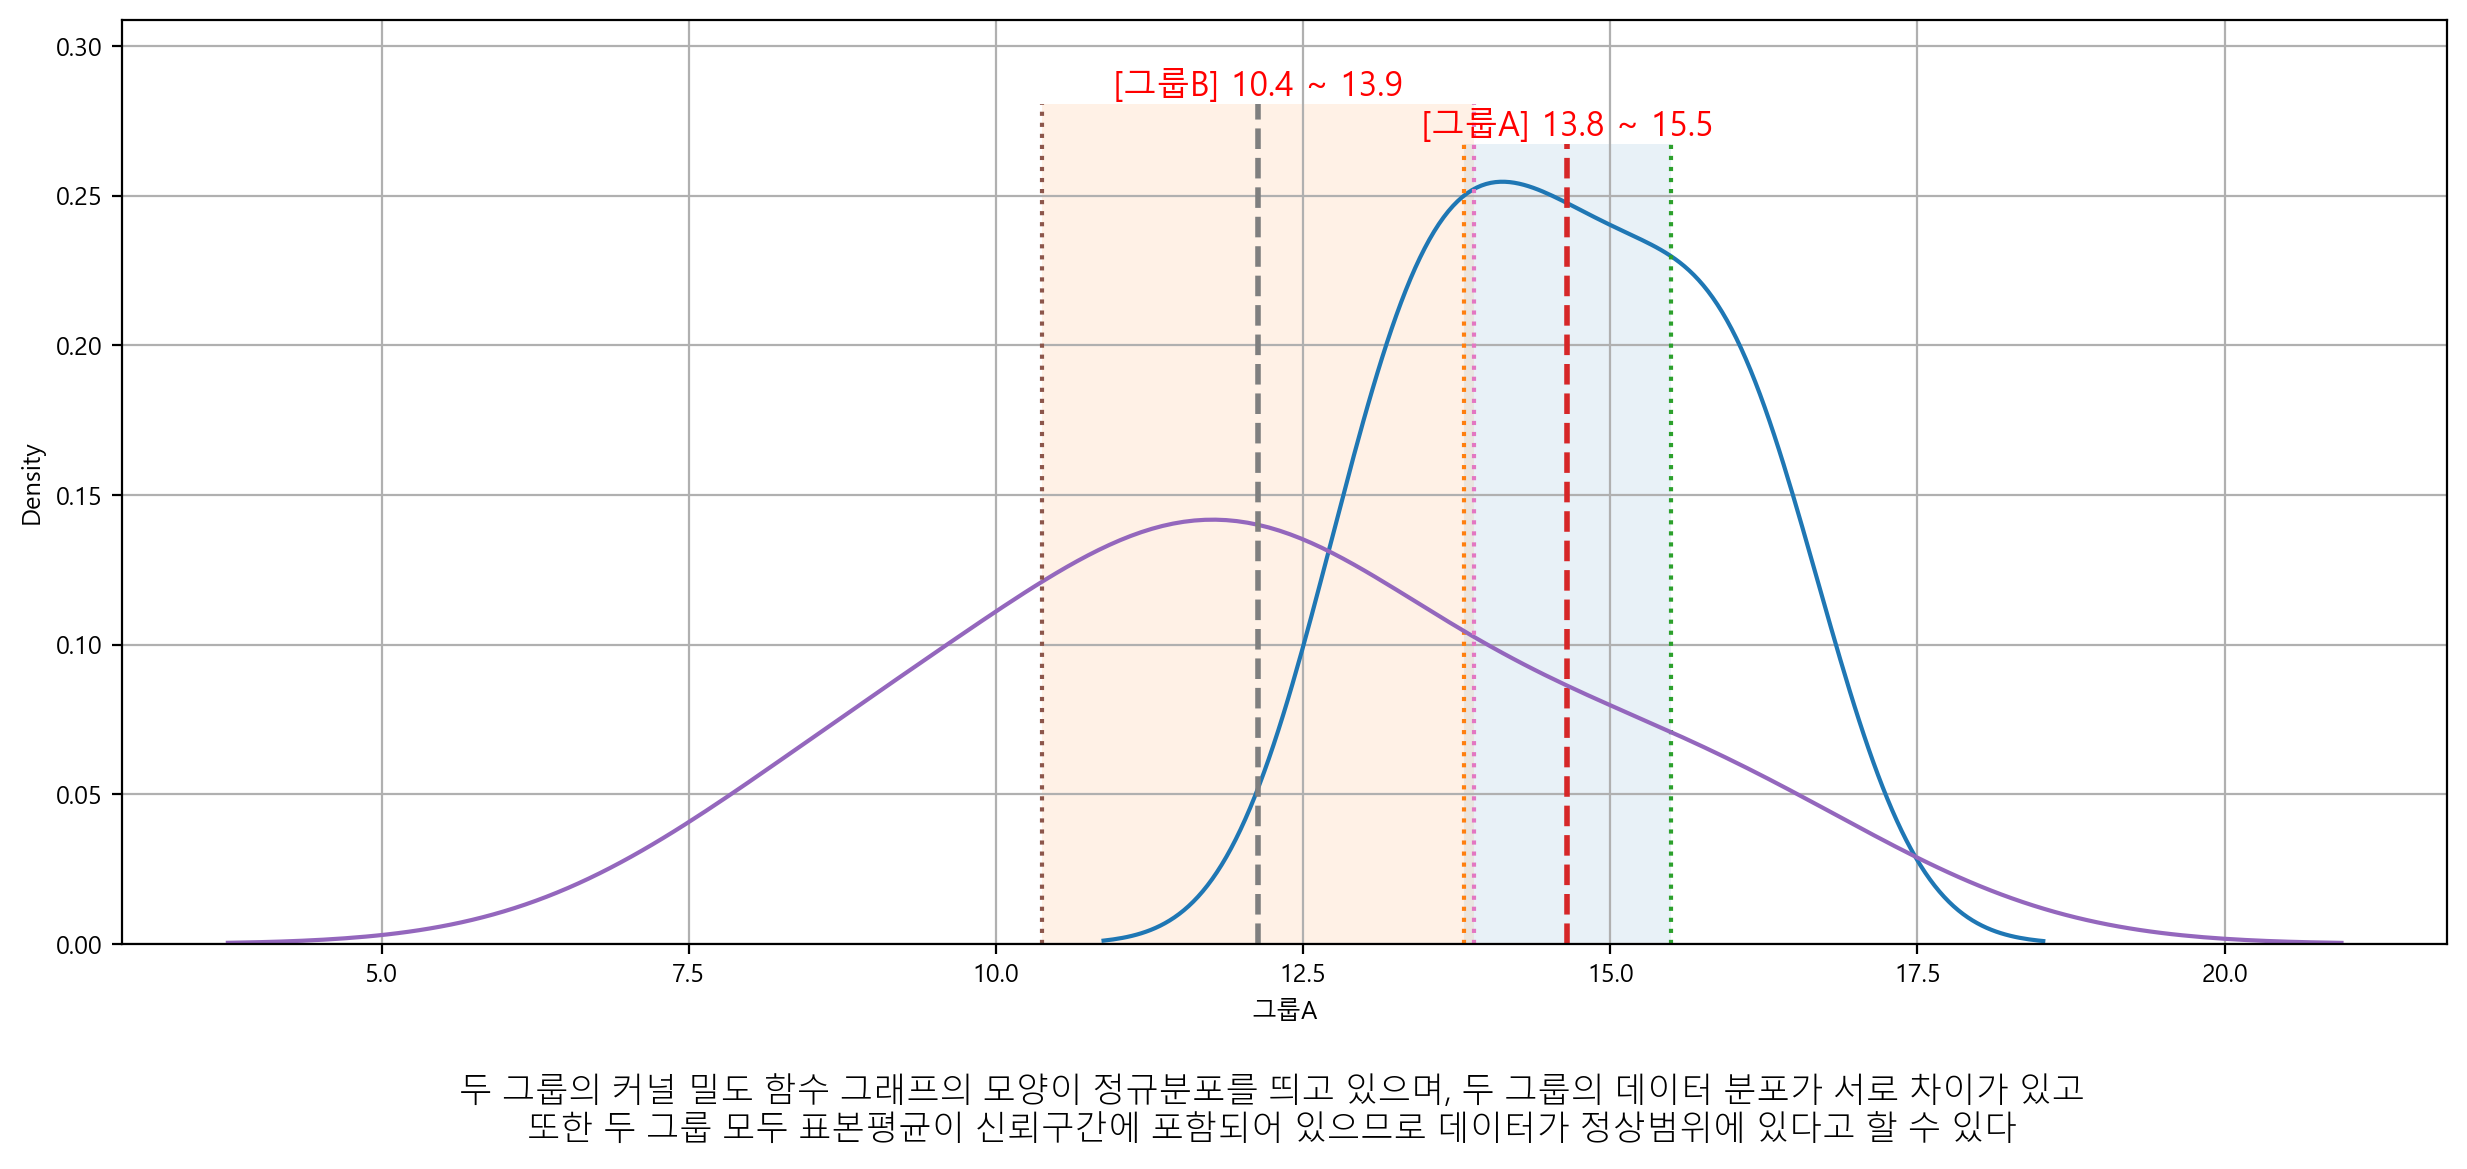

In [28]:
# 신뢰구간 확인
plt.figure()

for c in origin.columns:
    data = origin[c]                                  # 데이터만 추출
    max = data.max()                                  # 최대값
    clevel = 0.95                                     # 신뢰수준
    dof = len(data) - 1                               # 자유도 
    sample_mean = data.mean()                         # 표본평균
    sample_std = data.std(ddof=1)                     # 표본표준편차
    sample_std_error = sample_std / sqrt(len(data))   # 표본표준오차
    
    # 신뢰구간
    cmin, cmax = t.interval(clevel, dof, loc=sample_mean, scale=sample_std_error) 
    
    sns.kdeplot(data=data)
    
    xmin, xmax, ymin, ymax = plt.axis()
    
    # 신뢰구간 그리기 
    plt.plot([cmin, cmin], [ymin, ymax], linestyle=":")
    plt.plot([cmax, cmax], [ymin, ymax], linestyle=":")
    plt.fill_between([cmin, cmax], y1=0, y2=ymax, alpha=0.1)
    
    # 평균 그리기 
    plt.plot([sample_mean, sample_mean], [0, ymax], linestyle="--", linewidth=2)
    
    plt.text(x=(cmax - cmin) / 2 + cmin, 
             y=ymax, 
             s="[%s] %0.1f ~ %0.1f" % (c, cmin, cmax),
             horizontalalignment="center",
             verticalalignment="bottom",
             fontdict={"size": 12, "color": "red"})

plt.ylim(ymin, ymax * 1.1)

txt = """두 그룹의 커널 밀도 함수 그래프의 모양이 정규분포를 띄고 있으며, 두 그룹의 데이터 분포가 서로 차이가 있고 
또한 두 그룹 모두 표본평균이 신뢰구간에 포함되어 있으므로 데이터가 정상범위에 있다고 할 수 있다 """
plt.figtext(0.51, 0, txt, wrap=True, 
            verticalalignment="top", horizontalalignment="center",
            fontdict={"size":12, "weight": "light"})
plt.grid()
plt.show()

In [30]:
# 정규성 검정
for c in origin.columns:
    s, p = normaltest(origin[c])
    print("[{0}] statistic: {1:.3f}, p-value: {2:.3f}, 정규성 충족 여부 : {3}".format(c, s, p, p > 0.05))

[그룹A] statistic: 1.804, p-value: 0.406, 정규성 충족 여부 : True
[그룹B] statistic: 0.151, p-value: 0.927, 정규성 충족 여부 : True


In [31]:
# 등분산성
normal_dist = True        # 정규성 만족 여부 
data = origin.copy()      # 원본 데이터 복사 
fields = list(map(lambda x : data[x], data.columns)) 

if normal_dist:
    n = "Bartlett"
    s, p = bartlett(*fields)
    
else:
    n = "Levene"
    s, p = levene(*fields)
    
print("{0} 검정: statistic: {1:.3f}, p-value: {2:.3f}, 등분산성 충족 여부: {3}".format(n, s, p, p>0.05))

Bartlett 검정: statistic: 4.273, p-value: 0.039, 등분산성 충족 여부: False


##### 등분산성 만족하지 않을 경우 -> Mann-Whitney U 검정

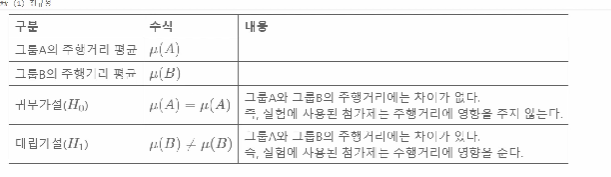

In [32]:
s, p = mannwhitneyu(origin['그룹A'], origin['그룹B'], alternative="two-sided")
"statistic: {0:.3f}, p-value: {1:.3f}, {2} 가설 채택".format(s, p, "대립" if p <= 0.05 else "귀무")

'statistic: 81.000, p-value: 0.021, 대립 가설 채택'

In [33]:
# 귀무가설 : 짧지 않다
# 대립가설 : 그룹 A 평균 주행거리가 짧다
s, p = mannwhitneyu(origin['그룹A'], origin['그룹B'], alternative="less")
"statistic: {0:.3f}, p-value: {1:.3f}, {2} 가설 채택".format(s, p, "대립" if p <= 0.05 else "귀무")

'statistic: 81.000, p-value: 0.991, 귀무 가설 채택'

In [34]:
# 귀무가설 : 길지 않다
# 대립가설 : 그룹 A 평균 주행거리가 길다
s, p = mannwhitneyu(origin['그룹A'], origin['그룹B'], alternative="greater")
"statistic: {0:.3f}, p-value: {1:.3f}, {2} 가설 채택".format(s, p, "대립" if p <= 0.05 else "귀무")

'statistic: 81.000, p-value: 0.010, 대립 가설 채택'

In [35]:
# 가설검정 시각화

df = pd.melt(origin, var_name="group", value_name="value")
df

,group,value
0,그룹A,13.2
1,그룹A,13.1
2,그룹A,16.3
3,그룹A,14.9
4,그룹A,14.2
5,그룹A,16.1
6,그룹A,15.1
7,그룹A,13.6
8,그룹A,15.8
9,그룹A,14.2


ValueError: Boolean array expected for the condition, not object

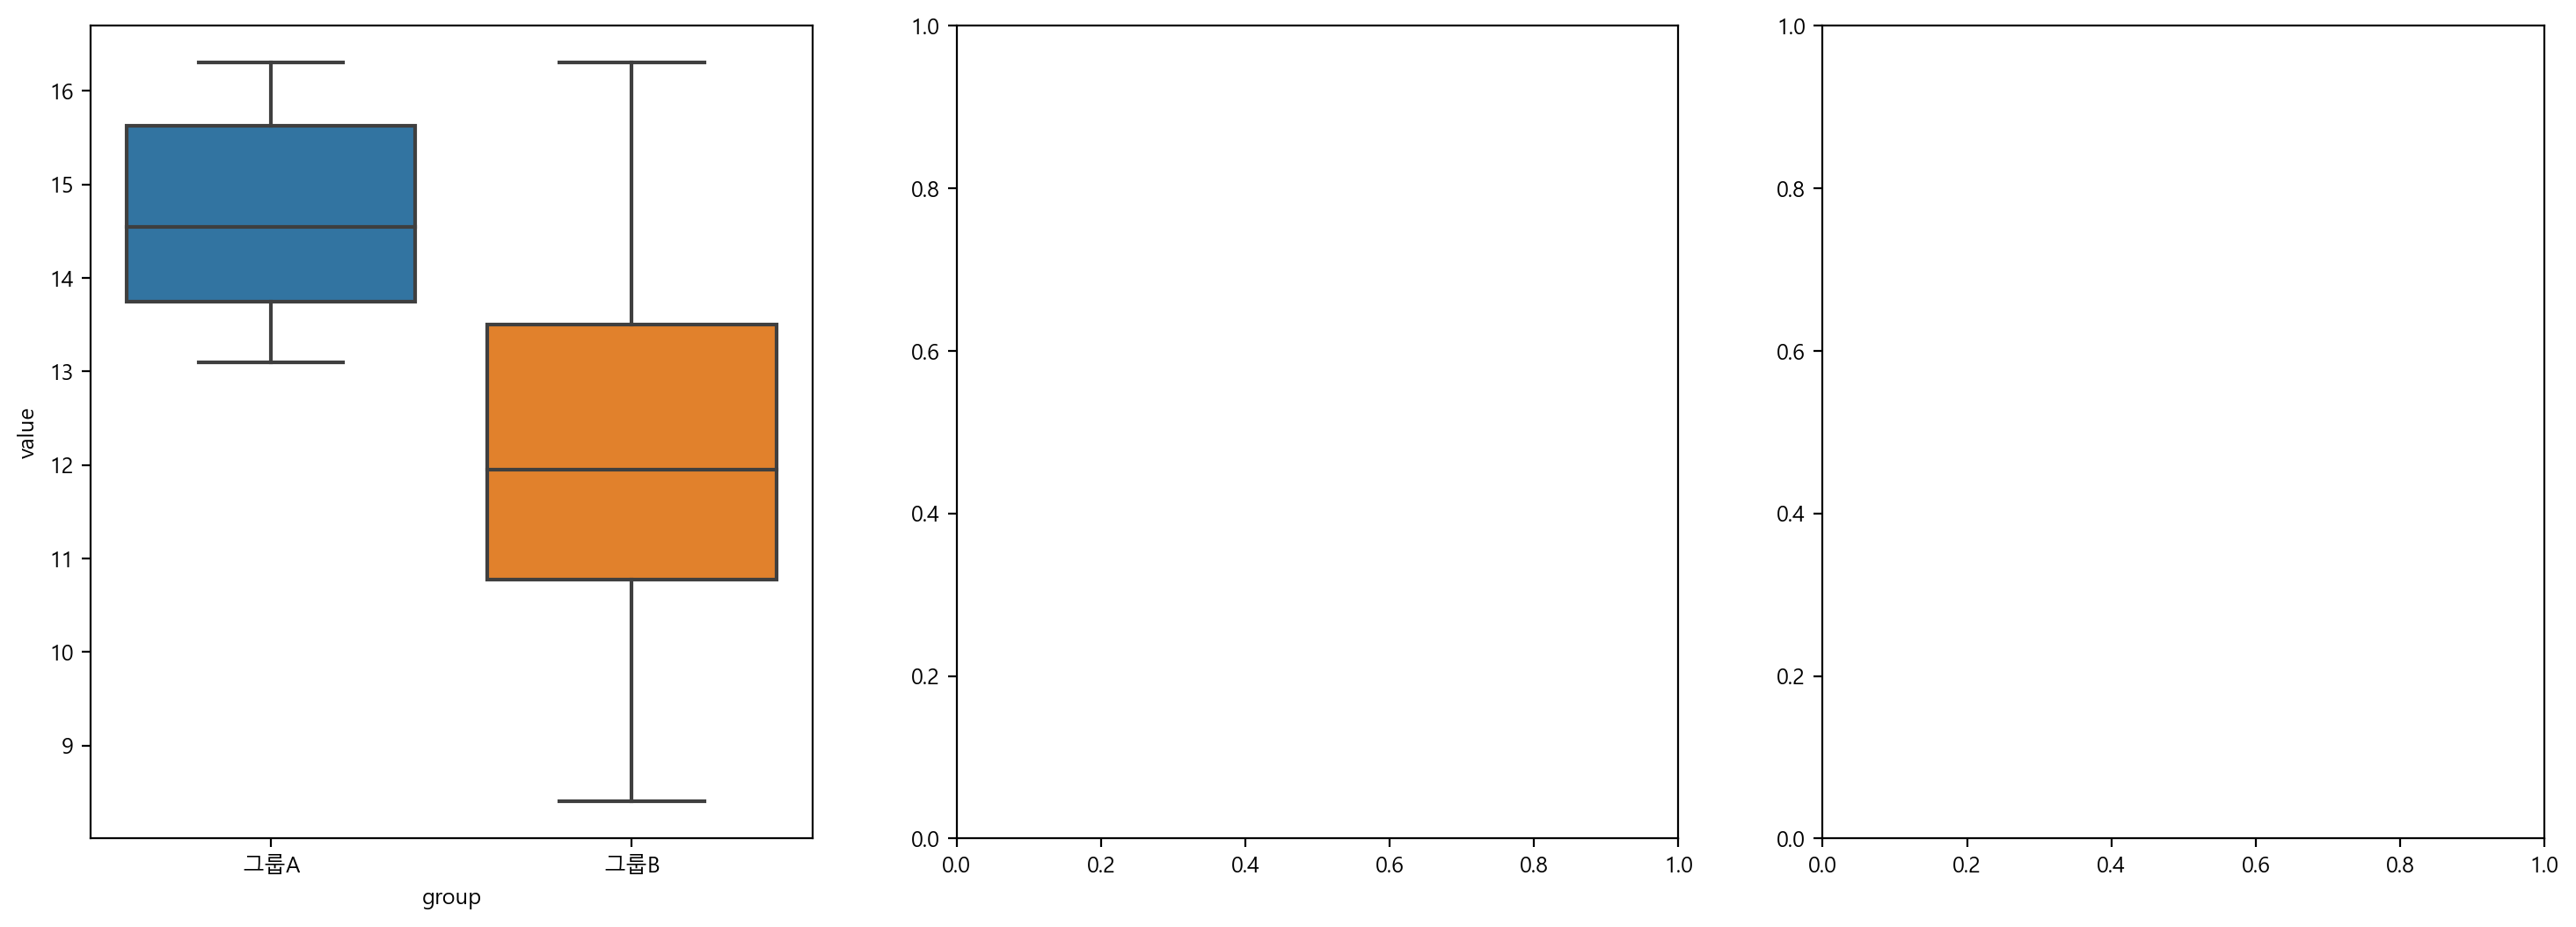

In [44]:
test = ["Mann-Whitney", "Mann-Whitney-ls", "Mann-Whitney-gt"]

config = {
    "data" : df,
    "x": "group",
    "y": "value",
    "pairs": [("그룹A", "그룹B")],
    "test": None,
    "text_format": "star",
    "loc": "outside"
}

fig, ax = plt.subplots(1, 3, figsize=(18, 6))

for i, v in enumerate(ax):
    config['test'] = test[i]
    
    k = sns.boxplot(ax=v, data = config['data'], x = config['x'], y = config['y'])
    # v.get_xaxis().axis_name
    
    annotator = Annotator(k, data=config['data'], x=config['data'], y  = config['y'], pairs = config['pairs'])
    annotator.configure(test=config['test'], text_format=config['text_format'], loc=config['loc'])
    annotator.apply_and_annotate()
    
    sns.despine(ax=v)
    
plt.show()